In [1]:
import numpy as np
import cv2
import os
import pandas as pd
import string
import matplotlib.pyplot as plt

from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
from keras.activations import relu, sigmoid, softmax
import keras.backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


## Tf GPU

In [2]:
import tensorflow as tf

#ignore warnings in the output
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
from tensorflow.python.client import device_lib

# Check all available devices if GPU is available
print(device_lib.list_local_devices())
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1285545176890885728
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2204421324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6193463540277717903
physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:02:00.0, compute capability: 6.1"
]
Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:02:00.0, compute capability: 6.1



In [4]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
with open('parser/words.txt') as f:
    contents = f.readlines()

lines = [line.strip() for line in contents] 
lines[0]

'a01-000u-00-00 ok 154 408 768 27 51 AT A'

## Preprocess Data
Data: [IAM Dataset](http://www.fki.inf.unibe.ch/databases/iam-handwriting-database/download-the-iam-handwriting-database)

Used in this project: [words.tgz](http://www.fki.inf.unibe.ch/DBs/iamDB/data/words/)

In [6]:
max_label_len = 0

char_list = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz" 

# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

print(char_list, len(char_list))

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(char_list.index(chara))
        
    return dig_lst

!"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz 78


In [7]:
images = []
labels = []

RECORDS_COUNT = 10000

In [8]:
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []

In [9]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
#     _, img = cv2.threshold(img, 
#                            128, 
#                            255, 
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    img = img / 255
    
    return img

## Generate train & validation set

In [10]:
for index, line in enumerate(lines):
    splits = line.split(' ')
    status = splits[1]
    
    if status == 'ok':
        word_id = splits[0]
        word = "".join(splits[8:])
        
        splits_id = word_id.split('-')
        filepath = 'words/{}/{}-{}/{}.png'.format(splits_id[0], 
                                                  splits_id[0], 
                                                  splits_id[1], 
                                                  word_id)
        
        # process image
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
        try:
            img = process_image(img)
        except:
            continue
            
        # process label
        try:
            label = encode_to_labels(word)
        except:
            continue
        
        if index % 10 == 0:
            valid_images.append(img)
            valid_labels.append(label)
            valid_input_length.append(31)
            valid_label_length.append(len(word))
            valid_original_text.append(word)
        else:
            train_images.append(img)
            train_labels.append(label)
            train_input_length.append(31)
            train_label_length.append(len(word))
            train_original_text.append(word)
        
        if len(word) > max_label_len:
            max_label_len = len(word)
    
    if index >= RECORDS_COUNT:
        break

In [11]:
# padded_label = pad_sequences(labels, 
#                              maxlen=max_label_len, 
#                              padding='post',
#                              value=len(char_list))

train_padded_label = pad_sequences(train_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

valid_padded_label = pad_sequences(valid_labels, 
                             maxlen=max_label_len, 
                             padding='post',
                             value=len(char_list))

In [12]:
train_padded_label.shape, valid_padded_label.shape

((7850, 16), (876, 16))

## Converts to Numpy array

In [13]:
# images = np.asarray(images)
# inputs_length = np.asarray(inputs_length)
# labels_length = np.asarray(labels_length)

train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [14]:
train_images.shape

(7850, 32, 128, 1)

## Build Model
Convolutional Recurrent Neural Network 

In [15]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)
# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

In [16]:
act_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 128, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 128, 64)       640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 32, 128)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 32, 256)        295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 32, 256)        5900

In [17]:
the_labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [18]:
batch_size = 8
epochs = 30
e = str(epochs)
optimizer_name = 'sgd'

In [19]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = optimizer_name, metrics=['accuracy'])

filepath="{}o-{}r-{}e-{}t-{}v.hdf5".format(optimizer_name,
                                          str(RECORDS_COUNT),
                                          str(epochs),
                                          str(train_images.shape[0]),
                                          str(valid_images.shape[0]))

checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [20]:
history = model.fit(x=[train_images, train_padded_label, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=([valid_images, valid_padded_label, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Train on 7850 samples, validate on 876 samples
Epoch 1/30
 - 127s - loss: 15.6089 - accuracy: 0.0000e+00 - val_loss: 14.5640 - val_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 14.56404, saving model to sgdo-10000r-30e-7850t-876v.hdf5
Epoch 2/30
 - 122s - loss: 13.2584 - accuracy: 0.0080 - val_loss: 18.6477 - val_accuracy: 0.0091

Epoch 00002: val_loss did not improve from 14.56404
Epoch 3/30
 - 124s - loss: 11.7394 - accuracy: 0.0478 - val_loss: 12.9375 - val_accuracy: 0.0571

Epoch 00003: val_loss improved from 14.56404 to 12.93753, saving model to sgdo-10000r-30e-7850t-876v.hdf5
Epoch 4/30
 - 123s - loss: 10.2167 - accuracy: 0.0749 - val_loss: 9.8962 - val_accuracy: 0.1016

Epoch 00004: val_loss improved from 12.93753 to 9.89617, saving model to sgdo-10000r-30e-7850t-876v.hdf5
Epoch 5/30
 - 123s - loss: 8.5125 - accuracy: 0.1185 - val_loss: 7.6667 - val_accuracy: 0.1587

Epoch 00005: val_loss improved from 9.89617 to 7.66674, saving model to sgdo-10000r-30e-7850t-

## Test accuracy
Using Jaro Distance & Ratio

In [21]:
# load the saved best model weights
act_model.load_weights(filepath)

# predict outputs on validation images
prediction = act_model.predict(valid_images)
 
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]
out = K.get_value(decoded)

import Levenshtein as lv

total_jaro = 0
total_rati = 0
# see the results
for i, x in enumerate(out):
    letters=''
    for p in x:
        if int(p) != -1:
            letters+=char_list[int(p)]
    total_jaro+=lv.jaro(letters, valid_original_text[i])
    total_rati+=lv.ratio(letters, valid_original_text[i])

print('jaro :', total_jaro/len(out))
print('ratio:', total_rati/len(out))

jaro : 0.9178220699054039
ratio: 0.8859288474703826


## Train accuracy

In [ ]:
# predict outputs on validation images
prediction = act_model.predict(train_images[150:170])
 
# use CTC decoder
decoded = K.ctc_decode(prediction,   
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

# see the results
for i, x in enumerate(out):
    print("original_text =  ", train_original_text[150+i])
    print("predicted text = ", end = '')
    for p in x:
        if int(p) != -1:
            print(char_list[int(p)], end = '')
    plt.imshow(train_images[150+i].reshape(32,128), cmap=plt.cm.gray)
    plt.show()
    print('\n')

In [23]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)

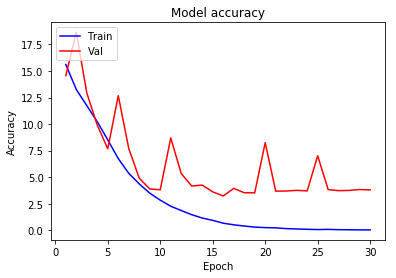

In [25]:
plotgraph(epochs, loss, val_loss)

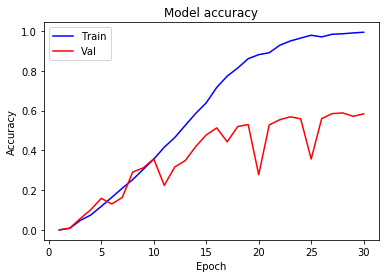

In [26]:
plotgraph(epochs, acc, val_acc)

In [27]:
# get best model index
minimum_val_loss = np.min(history.history['val_loss'])
best_model_index = np.where(history.history['val_loss'] == minimum_val_loss)[0][0]

best_loss = str(history.history['loss'][best_model_index])
best_acc = str(history.history['accuracy'][best_model_index])
best_val_loss = str(history.history['val_loss'][best_model_index])
best_val_acc = str(history.history['val_accuracy'][best_model_index])

In [28]:
with open('history.txt', 'a') as f:
    new_data = '{},{},{},{},{},{},{},{},{},{}\n'.format(filepath, 
                                                      optimizer_name, 
                                                      str(RECORDS_COUNT), 
                                                      e, 
                                                      str(train_images.shape[0]),
                                                      str(valid_images.shape[0]), 
                                                      best_loss, 
                                                      best_acc, 
                                                      best_val_loss, 
                                                      best_val_acc)
    f.write(new_data)